## Space for general project notes

# Design Principles

- sentinel 1,2 and future mission data should be able to be processed using generic pixel extraction tools. 
- main operations include extracting mean pixel values from a region of interest.

The current system uses sentinelFile class to do file opening operations on each .jp2 image and the sentinelGranule to hold a single data package together (i.e. a collection of sentinelFile instances as a multispectral stack).

## 1.1 Naming Convention

'Image' (i.e. sentinelTwoImage) refers to a 2D pixel array stored in a file. The image sentinelImage classes should all have a .data attribute which is directly indexable. Multiple image instances may refer to the same file, but should be used to address different 2D arrays within a file. This is not an explicit requirement of the image instances however. For MSI files from within a sentinel 2 package, each instance might be a different spectral band. For sentinel 1, an image may be a 2D array of values representing a radar polarisation state. The important assumption is that the data should be 2D and projected into a meaningful spatial domain. In the specific context of the sentinelpy package, any image class should also contain explicit georeferencing information (i.e. grid projection, extents).

All image objects should have an element which behaves like an array

'Granule' (i.e. sentinelTwoGranule) refers to an image or collection of images with the same spatial domains (i.e multiple sentinelTwoImages, with each band representing a different waveband's reflectance for a defined spatial region). Granules should not permit partially overlapping/ non-overlapping images to be stored in the same instance of a granule. Different resolution images may be stored in the same instance of a granule, however the transformation between spatial resolutions should be defined within the granule. Granules should contain the capture date and the all the georeferencing  information (this means images might not need georeferencing information to be contained)

'Region Of Interest' or 'ROI' is defined as a spatial region which may be defined by a series of points forming a boundary. Therefore the pixels of an image may be contained within a ROI, however a ROI does not need to explicitly be contained by a pixel array.

The words 'raster' and 'image' are used interchangeably [did I understand right? or if not, what's the difference again? thanks - Sarah].

The batchProcessor class should be used to do any vector-to-raster or raster-to-raster operation (for example, postage stamp extraction). This class accepts a single granule object and a list of ROI objects. The purpose of the class is to minimise file open operations which can significantly slow down the workflow.

## 1.2 Object naming

classes should use the format: thisIsAClassName

class variables should use the format: classVariable

user callable methods should use the format: this_is_a_public_method

private methods should uset the format: _this_is_a_private_method

# Demonstration

## 2.1 Basic I/O

Sentinel 2 Granules are read in using the sentinelTwoGranule class. Simply specify which grid square (older format had multiple grid squares in each folder) as follows:

In [1]:
import sentinelPy as sp
import matplotlib.pyplot as plt
# import a test granule

# NOTE: you'll need to put this granule (or a symlink)
# in the working directory in order to continue running this workbook

gran = sp.sentinelTwoGranule(
    mgrsGridSquare='30UXC',
    safeFolderPath='S2A_MSIL2A_20170601T110651_N0205_R137_T30UXC_20170601T111225.SAFE'
)

Using this class, we can identify the capture date:

In [2]:
print(gran.captureDate)

2017-06-01


check the process level:

In [3]:
gran.processLevel

'Level-2Ap'

or generate a quick ipython preview:

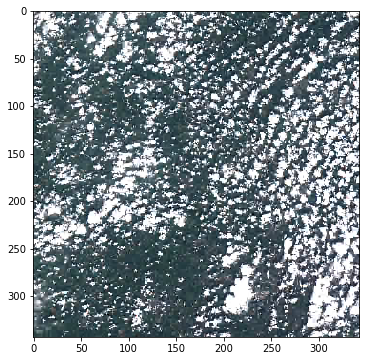

In [4]:
gran.imshow()
plt.show()

Similarly, individual Regions of Interest (ROIs) are defined using the sentinelROI class:

In [5]:
wholeFarm = sp.sentinelROI('test_field.geojson')

From this class, we can access various coordinates (needs a tidy up):

In [6]:
# bounding box in UTM (WG84) coordinates
wholeFarm.bboxUtm

((604835.0, 5783853.0),
 (606338.0, 5783853.0),
 (606338.0, 5781515.0),
 (604835.0, 5781515.0),
 (604835.0, 5783853.0))

## 2.2 "Postage stamp" cutout

As this is a batch processing operation, we use the batchProcessor class which allows us to cut out multiple areas from the same granule.

An instance of the class is first defined:

In [7]:
gaydonProcessor = sp.batchProcessor(gran,[wholeFarm])

Note: the default is to do the read operations automatically. To prevent  this, use readFiles=False.

To return the np arrays, call the as_NP_arrays method:

In [8]:
small_arrays = gaydonProcessor.make_arrays(storeArrays=False)

This gives an m x n x waveband numpy array:

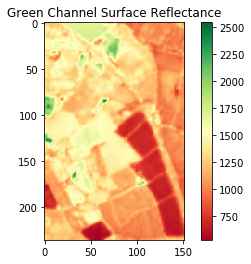

In [9]:
import matplotlib.pyplot as plt

plt.imshow(small_arrays[0][:,:,3],cmap='RdYlGn')
plt.title('Green Channel Surface Reflectance')
plt.colorbar()
plt.show()

The pixel coordinates of the bounding box can be extracted (in format (ymin,ymax,xmin,xmax) ):

In [10]:
gaydonProcessor.pix10

[(1614, 1850, 482, 634)]

There are 10 wavebands:

In [11]:
gaydonProcessor.bandNames

['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

the ESA specified waveband centres for these are:

In [12]:
gaydonProcessor.bandCentres

[496.6, 560.0, 664.5, 703.9, 740.2, 782.5, 835.1, 864.8, 1613.7, 2202.4]

If you only need to extract a single waveband, this can be done by specifying:

In [13]:
gaydonProcessor.make_arrays(waveBand='B05')

which gives a 2D m x n waveband

In [14]:
gaydonProcessor.as_NP_arrays()[0].shape

(236, 152)

The UTM coordinates of each ROI are stored here:

In [15]:
gaydonProcessor.newRefPixUtm

[(604825, 5783875)]

## 2.2 Getting a mean spectrum

A crude method for getting a mean spectrum for the ROI is included, although please note that this takes an average over the whole cutout rather than exactly the area specified by the ROI coordinates

In [16]:
spectra = gaydonProcessor.as_mean_spectrum()

Lets plot these in matplotlib:

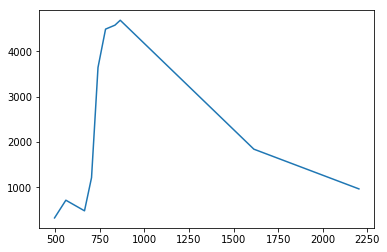

In [17]:
for spectrum in spectra:
    plt.plot(gaydonProcessor.bandCentres,
            spectrum)
plt.show()

## 2.3 Combining ROIs

If you want to view an area containing all of your ROIs, use the method:

In [18]:
gaydonProcessor.combine_ROIs()

you can then make an array (as above) of the area covering all ROIs:

In [19]:
gaydonProcessor.as_NP_arrays()[0].shape

(238, 154, 10)

(Note that once you've combined ROIs you can't uncombine them again.)

## 2.4 RGB images

There's a quick function for RGB images:

In [20]:
gran.SCL.layerNames

{0: 'NODATA',
 1: 'SATURATED_DEFECTIVE',
 2: 'DARK_FEATURE_SHADOW',
 3: 'CLOUD_SHADOW',
 4: 'VEGETATION',
 5: 'BARE_SOIL_DESERT',
 6: 'WATER',
 7: 'CLOUD_LOW_PROBA',
 8: 'CLOUD_MEDIUM_PROBA',
 9: 'CLOUD_HIGH_PROBA',
 10: 'THIN_CIRRUS',
 11: 'SNOW_ICE'}

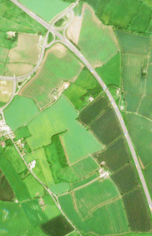

In [21]:
gaydonImages = sp.batchProcessor(gran,[wholeFarm])
# this time use the Scene Classification Masking function to generate a mask with 
gaydonImages.make_arrays(mask=True,excludedLayers=[0,1,2,3,7,8,9,10,11])
gaydonImages.as_RGB_images()[0]

SCL layers and pixels outside the ROI can be masked out with the mask==True and supplying a list of layers to exclude

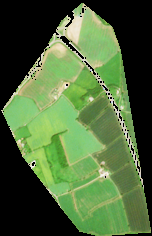

In [22]:
gaydonImages.as_RGB_images(mask=True)[0]

## 2.5 Array Masking

The NP arrays can also be converted to masked arrays with the mask=True command.

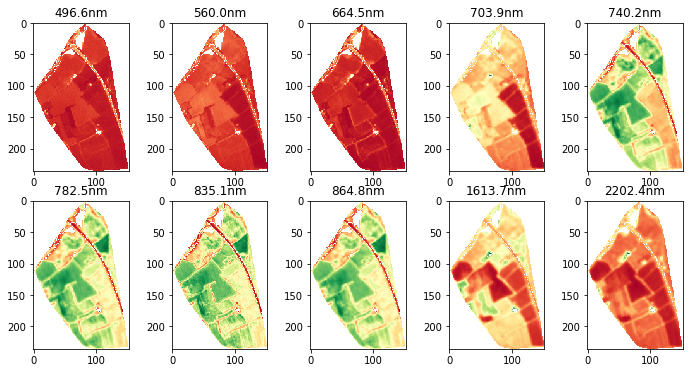

In [23]:
# reprocess the arrays to exclude Bare Soil classified pixels:
gaydonImages.make_arrays(mask=True,excludedLayers=[5])

# and plot
fig = plt.figure(figsize = (12,6))

for i in range(10):
    a = fig.add_subplot(2,5,i+1)
    plt.imshow(gaydonImages.as_NP_arrays()[0][:,:,i],cmap='RdYlGn')
    a.set_title(str(gaydonImages.bandCentres[i])+'nm')
plt.show()

# Current Development

Wishlist:
- implement cloud masking for individual pixel exclusion [x]
- add sentinelOne capability